In [1]:
# Import libraries 

import numpy as np
import os
import pandas as pd

from datetime import datetime, timedelta
from dotenv import load_dotenv
 
from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical.stock import StockHistoricalDataClient
from  alpaca.data.timeframe import TimeFrame, TimeFrameUnit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import hvplot.pandas
import holoviews as hv
hv.extension("bokeh")

import plotly.express as px
import plotly.graph_objects as go



In [2]:
# Load .env file

load_dotenv()

True

In [3]:
# Set Alpaca API key and secret

ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_API_SECRET")
client = StockHistoricalDataClient(ALPACA_API_KEY, ALPACA_SECRET_KEY)

# Create the Alpaca API object

timeframe = TimeFrame(5, TimeFrameUnit.Minute)
symbol = 'TSLA'
start = datetime.utcnow() - timedelta(days=5)
end=datetime.utcnow() - timedelta(days=1)
request = StockBarsRequest(symbol_or_symbols=symbol, start=start, end=end, timeframe=timeframe)

In [4]:
source_df = client.get_stock_bars(request).df.tz_convert('America/New_York', level=1)

In [5]:
display(source_df.tail())

open      high     low     close  \
symbol timestamp                                                         
TSLA   2024-02-21 11:10:00-05:00  194.7300  195.3700  194.61  194.8611   
       2024-02-21 11:15:00-05:00  194.8700  195.3699  194.64  195.3050   
       2024-02-21 11:20:00-05:00  195.3050  195.4400  194.28  194.7400   
       2024-02-21 11:25:00-05:00  194.7570  195.1350  193.95  194.0600   
       2024-02-21 11:30:00-05:00  194.0799  194.1900  193.71  194.1200   

                                     volume  trade_count        vwap  
symbol timestamp                                                      
TSLA   2024-02-21 11:10:00-05:00  1193641.0      19039.0  195.025000  
       2024-02-21 11:15:00-05:00  1168009.0      18576.0  194.930842  
       2024-02-21 11:20:00-05:00  1458341.0      11730.0  194.802368  
       2024-02-21 11:25:00-05:00  1618820.0      13181.0  194.435504  
       2024-02-21 11:30:00-05:00  1300289.0      10227.0  193.959131

In [6]:
bars_df = source_df.copy()
# pct_change is profit from last close
bars_df["pct_change"] = bars_df["close"].pct_change()
# signal for when we want to be in or out of a stock
bars_df["signal"] = np.where(bars_df["pct_change"] > 0, 1.0, 0.0)
# reaction is the signal diff
bars_df["reaction"] = bars_df["signal"].diff()
# action is if we could perfectly predict the next close
bars_df["action"] = bars_df["reaction"].shift(-1)
# these values are the high, low, and open as a percentage of the current close
bars_df["high %"] = (bars_df["high"] - bars_df["close"])/bars_df["close"]
bars_df["low %"] = (bars_df["low"] - bars_df["close"])/bars_df["close"]
bars_df["open %"] = (bars_df["open"] - bars_df["close"])/bars_df["close"]

In [7]:
# So we want to add the high, low, and open for the 15 minute and 60 minute window
minutes = 5
windows = [3, 12]

In [8]:
for window in windows:
    wm = window*minutes
    # compute the rolling high, low, open for a given window.  the close is the same at this time for all windows
    bars_df[f"high - {wm}"] = bars_df["high"].rolling(window=window).max()
    bars_df[f"low - {wm}"] = bars_df["low"].rolling(window=window).min()
    bars_df[f"open - {wm}"] = bars_df["open"].shift(periods=window-1)
    bars_df[f"close - {wm}"] = bars_df["close"].shift(periods=window-1)
    # these values are the high, low, and open as a percentage of the current close
    bars_df[f"high % - {wm}"] = (bars_df[f"high - {wm}"] - bars_df["close"])/bars_df["close"]
    bars_df[f"low % - {wm}"] = (bars_df[f"low - {wm}"] - bars_df["close"])/bars_df["close"]
    bars_df[f"open % - {wm}"] = (bars_df[f"open - {wm}"] - bars_df["close"])/bars_df["close"]
    bars_df[f"close % - {wm}"] = (bars_df[f"close - {wm}"] - bars_df["close"])/bars_df["close"]

In [9]:
display(bars_df.head(100))
display(bars_df.tail(100))

open      high     low     close  \
symbol timestamp                                                         
TSLA   2024-02-20 04:00:00-05:00  196.9800  198.2300  196.37  197.3000   
       2024-02-20 04:05:00-05:00  197.1900  197.3600  196.82  196.8200   
       2024-02-20 04:10:00-05:00  196.8200  197.1100  196.72  197.1100   
       2024-02-20 04:15:00-05:00  197.1500  197.5000  197.06  197.2400   
       2024-02-20 04:20:00-05:00  197.1800  197.2900  197.00  197.0000   
...                                    ...       ...     ...       ...   
       2024-02-20 11:55:00-05:00  191.8450  192.1185  191.33  191.3501   
       2024-02-20 12:00:00-05:00  191.3600  191.3800  190.30  190.3214   
       2024-02-20 12:05:00-05:00  190.3172  190.6300  190.05  190.1000   
       2024-02-20 12:10:00-05:00  190.0900  190.3900  189.72  189.8808   
       2024-02-20 12:15:00-05:00  189.8700  189.9999  189.38  189.4157   

                                     volume  trade_count        vwap  \
symbol timestamp                                                       
TSLA   2024-02-20 04:00:00-05:00    45358.0       1353.0  197.439241   
       2024-02-20 04:05:00-05:00    17128.0        523.0  197.046080   
       2024-02-20 04:10:00-05:00    23857.0        548.0  196.912064   
       2024-02-20 04:15:00-05:00    17774.0        460.0  197.375357   
       2024-02-20 04:20:00-05:00     7822.0        367.0  197.117828   
...                                     ...          ...         ...   
       2024-02-20 11:55:00-05:00   921445.0       9791.0  191.769544   
       2024-02-20 12:00:00-05:00  1596715.0      18533.0  190.788006   
       2024-02-20 12:05:00-05:00  1335448.0      11658.0  190.290828   
       2024-02-20 12:10:00-05:00  1596768.0      20904.0  190.013529   
       2024-02-20 12:15:00-05:00  1383978.0      13199.0  189.682267   

                                  pct_change  signal  reaction  ...  \
symbol timestamp                                                ...   
TSLA   2024-02-20 04:00:00-05:00         NaN     0.0       NaN  ...   
       2024-02-20 04:05:00-05:00   -0.002433     0.0       0.0  ...   
       2024-02-20 04:10:00-05:00    0.001473     1.0       1.0  ...   
       2024-02-20 04:15:00-05:00    0.000660     1.0       0.0  ...   
       2024-02-20 04:20:00-05:00   -0.001217     0.0      -1.0  ...   
...                                      ...     ...       ...  ...   
       2024-02-20 11:55:00-05:00   -0.002581     0.0       0.0  ...   
       2024-02-20 12:00:00-05:00   -0.005376     0.0       0.0  ...   
       2024-02-20 12:05:00-05:00   -0.001163     0.0       0.0  ...   
       2024-02-20 12:10:00-05:00   -0.001153     0.0       0.0  ...   
       2024-02-20 12:15:00-05:00   -0.002449     0.0       0.0  ...   

                                  open % - 15  close % - 15  high - 60  \
symbol timestamp                                                         
TSLA   2024-02-20 04:00:00-05:00          NaN           NaN        NaN   
       2024-02-20 04:05:00-05:00          NaN           NaN        NaN   
       2024-02-20 04:10:00-05:00    -0.000660      0.000964        NaN   
       2024-02-20 04:15:00-05:00    -0.000253     -0.002129        NaN   
       2024-02-20 04:20:00-05:00    -0.000914      0.000558        NaN   
...                                       ...           ...        ...   
       2024-02-20 11:55:00-05:00     0.005173      0.005121   193.7486   
       2024-02-20 12:00:00-05:00     0.010501      0.008007   193.7486   
       2024-02-20 12:05:00-05:00     0.009179      0.006576   193.7486   
       2024-02-20 12:10:00-05:00     0.007790      0.002320   193.7486   
       2024-02-20 12:15:00-05:00     0.004759      0.003613   193.2400   

                                  low - 60  open - 60  close - 60  \
symbol timestamp                                                    
TSLA   2024-02-20 04:00:00-05:00       NaN        NaN         NaN   
       2024-02-20 04:05:00-05:00       NaN  

open      high     low     close  \
symbol timestamp                                                         
TSLA   2024-02-20 19:00:00-05:00  192.9400  192.9400  192.90  192.9100   
       2024-02-20 19:05:00-05:00  192.9000  192.9300  192.83  192.9000   
       2024-02-20 19:10:00-05:00  192.8700  192.8700  192.76  192.8000   
       2024-02-20 19:15:00-05:00  192.8000  192.8000  192.70  192.7000   
       2024-02-20 19:20:00-05:00  192.6500  192.7200  192.61  192.7199   
...                                    ...       ...     ...       ...   
       2024-02-21 11:10:00-05:00  194.7300  195.3700  194.61  194.8611   
       2024-02-21 11:15:00-05:00  194.8700  195.3699  194.64  195.3050   
       2024-02-21 11:20:00-05:00  195.3050  195.4400  194.28  194.7400   
       2024-02-21 11:25:00-05:00  194.7570  195.1350  193.95  194.0600   
       2024-02-21 11:30:00-05:00  194.0799  194.1900  193.71  194.1200   

                                     volume  trade_count        vwap  \
symbol timestamp                                                       
TSLA   2024-02-20 19:00:00-05:00     1849.0         91.0  192.918046   
       2024-02-20 19:05:00-05:00     4868.0        136.0  192.884879   
       2024-02-20 19:10:00-05:00    10544.0        167.0  192.813098   
       2024-02-20 19:15:00-05:00    14551.0        188.0  192.750829   
       2024-02-20 19:20:00-05:00     7581.0        137.0  192.663388   
...                                     ...          ...         ...   
       2024-02-21 11:10:00-05:00  1193641.0      19039.0  195.025000   
       2024-02-21 11:15:00-05:00  1168009.0      18576.0  194.930842   
       2024-02-21 11:20:00-05:00  1458341.0      11730.0  194.802368   
       2024-02-21 11:25:00-05:00  1618820.0      13181.0  194.435504   
       2024-02-21 11:30:00-05:00  1300289.0      10227.0  193.959131   

                                  pct_change  signal  reaction  ...  \
symbol timestamp                                                ...   
TSLA   2024-02-20 19:00:00-05:00    0.000000     0.0       0.0  ...   
       2024-02-20 19:05:00-05:00   -0.000052     0.0       0.0  ...   
       2024-02-20 19:10:00-05:00   -0.000518     0.0       0.0  ...   
       2024-02-20 19:15:00-05:00   -0.000519     0.0       0.0  ...   
       2024-02-20 19:20:00-05:00    0.000103     1.0       1.0  ...   
...                                      ...     ...       ...  ...   
       2024-02-21 11:10:00-05:00    0.000651     1.0       1.0  ...   
       2024-02-21 11:15:00-05:00    0.002278     1.0       0.0  ...   
       2024-02-21 11:20:00-05:00   -0.002893     0.0      -1.0  ...   
       2024-02-21 11:25:00-05:00   -0.003492     0.0       0.0  ...   
       2024-02-21 11:30:00-05:00    0.000309     1.0       1.0  ...   

                                  open % - 15  close % - 15  high - 60  \
symbol timestamp                                                         
TSLA   2024-02-20 19:00:00-05:00    -0.000052      0.000933   193.5600   
       2024-02-20 19:05:00-05:00     0.000570      0.000052   193.5600   
       2024-02-20 19:10:00-05:00     0.000726      0.000571   193.5600   
       2024-02-20 19:15:00-05:00     0.001038      0.001038   193.5500   
       2024-02-20 19:20:00-05:00     0.000779      0.000416   193.4000   
...                                       ...           ...        ...   
       2024-02-21 11:10:00-05:00     0.000764     -0.000031   198.0800   
       2024-02-21 11:15:00-05:00    -0.002291     -0.002922   197.2096   
       2024-02-21 11:20:00-05:00    -0.000051      0.000622   196.6800   
       2024-02-21 11:25:00-05:00     0.004174      0.006416   196.6700   
       2024-02-21 11:30:00-05:00     0.006104      0.003194   196.4300   

                                  low - 60  open - 60  close - 60  \
symbol timestamp                                                    
TSLA   2024-02-20 19:00:00-05:00    192.76   193.2300    193.2700   
       2024-02-20 19:05:00-05:00    192.76  

In [10]:
bars_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 280 entries, ('TSLA', Timestamp('2024-02-20 04:00:00-0500', tz='America/New_York')) to ('TSLA', Timestamp('2024-02-21 11:30:00-0500', tz='America/New_York'))
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          280 non-null    float64
 1   high          280 non-null    float64
 2   low           280 non-null    float64
 3   close         280 non-null    float64
 4   volume        280 non-null    float64
 5   trade_count   280 non-null    float64
 6   vwap          280 non-null    float64
 7   pct_change    279 non-null    float64
 8   signal        280 non-null    float64
 9   reaction      279 non-null    float64
 10  action        279 non-null    float64
 11  high %        280 non-null    float64
 12  low %         280 non-null    float64
 13  open %        280 non-null    float64
 14  high - 15     278 non-null    float64
 15  low - 15      278 non-n

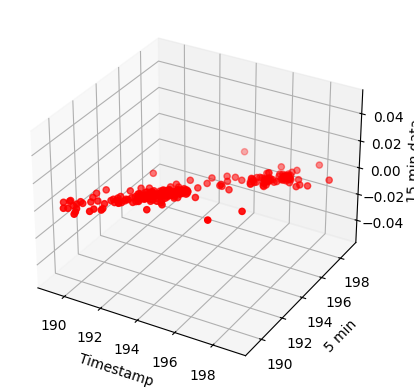

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# plot
ax.scatter(bars_df["close"],bars_df["close - 15"], c = "r", marker = "o")

# set labels
ax.set_xlabel("Timestamp")
ax.set_ylabel("5 min")
ax.set_zlabel("15 min data")

plt.show()



In [12]:
bars_df = bars_df.droplevel(level=0)

bars_df.head()

,open,high,low,close,volume,trade_count,vwap,pct_change,signal,reaction,...,open % - 15,close % - 15,high - 60,low - 60,open - 60,close - 60,high % - 60,low % - 60,open % - 60,close % - 60
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-02-20 04:00:00-05:00,196.98,198.23,196.37,197.30,45358.0,1353.0,197.439241,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-20 04:05:00-05:00,197.19,197.36,196.82,196.82,17128.0,523.0,197.046080,-0.002433,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-20 04:10:00-05:00,196.82,197.11,196.72,197.11,23857.0,548.0,196.912064,0.001473,1.0,1.0,...,-0.000660,0.000964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-20 04:15:00-05:00,197.15,197.50,197.06,197.24,17774.0,460.0,197.375357,0.000660,1.0,0.0,...,-0.000253,-0.002129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-20 04:20:00-05:00,197.18,197.29,197.00,197.00,7822.0,367.0,197.117828,-0.001217,0.0,-1.0,...,-0.000914,0.000558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
bars_df["time_normalized"] = (bars_df.index - bars_df.index[0]).total_seconds()/60

scatter_plot = px.scatter_3d(bars_df, x="close", y="close - 15", z="time_normalized",
color_discrete_map={"close":"red","close - 15":"blue"})

scatter_plot

In [14]:
# 3d scatter plot for OHLC data

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=bars_df["time_normalized"],
    y=bars_df["time_normalized"],
    z=bars_df["close"],
    mode = "markers",
    marker = dict(size=4, color="blue"),
    name = "OHLC data"
))

In [15]:
inner_ellipsoid_centers = bars_df[['close', 'close - 15']].values
inner_ellipsoid_radii = bars_df[['close', 'close - 15']].subtract(bars_df[['open', 'open - 15']]).values / 2

outer_ellipsoid_centers = bars_df[['high', 'high - 15']].values
outer_ellipsoid_radii = bars_df[['high', 'high - 15']].subtract(bars_df[['low', 'low - 15']]).values / 2


In [16]:
print(inner_ellipsoid_centers)

[[197.3         nan]
 [196.82        nan]
 [197.11   197.3   ]
 [197.24   196.82  ]
 [197.     197.11  ]
 [196.67   197.24  ]
 [196.1    197.    ]
 [196.4    196.67  ]
 [196.39   196.1   ]
 [196.5    196.4   ]
 [196.5    196.39  ]
 [196.21   196.5   ]
 [196.     196.5   ]
 [195.7    196.21  ]
 [196.07   196.    ]
 [195.92   195.7   ]
 [195.89   196.07  ]
 [196.     195.92  ]
 [196.5    195.89  ]
 [196.6    196.    ]
 [196.57   196.5   ]
 [196.64   196.6   ]
 [196.39   196.57  ]
 [196.5    196.64  ]
 [196.33   196.39  ]
 [196.1    196.5   ]
 [196.38   196.33  ]
 [196.44   196.1   ]
 [196.44   196.38  ]
 [196.3    196.44  ]
 [196.42   196.44  ]
 [196.54   196.3   ]
 [196.8    196.42  ]
 [196.88   196.54  ]
 [196.96   196.8   ]
 [196.99   196.88  ]
 [197.1    196.96  ]
 [197.1    196.99  ]
 [197.28   197.1   ]
 [197.05   197.1   ]
 [196.97   197.28  ]
 [197.     197.05  ]
 [197.02   196.97  ]
 [197.28   197.    ]
 [197.19   197.02  ]
 [197.1    197.28  ]
 [197.1    197.19  ]
 [197.3    19

In [17]:
for i in range(len(inner_ellipsoid_centers)):
    fig.add_trace(go.Mesh3d(
        x=inner_ellipsoid_centers[i, 0],
        y=inner_ellipsoid_centers[i, 1],
        z=bars_df['time_normalized'][i],
        opacity=0.5,  # Inner ellipsoid opacity
        color='red',  # Inner ellipsoid color
        sizemode='absolute',
        sizeref=inner_ellipsoid_radii[i, 0],  # Set size reference to the radius of the ellipsoid
        xaxis='x',
        yaxis='y',
        zaxis='z',
        name='Inner Ellipsoid'
    ))

/var/folders/sr/78cv2dx14kgdcwtf90634z580000gn/T/ipykernel_11990/2004110499.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



ValueError: 
    Invalid value of type 'numpy.float64' received for the 'x' property of mesh3d
        Received value: 197.3

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series